# Personalized Medicine: Redefining Cancer Treatment

# Preprocessing Stage
---
Import necessary libraries, load train/test data into pandas dataframes and visualize some examples

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle
from time import time
from IPython.display import display
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords 
import string

# Sci-kit Learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import log_loss, classification_report, accuracy_score, confusion_matrix
from sklearn import __version__

# Imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imb_pipeline
from imblearn import __version__ as imblearn_version

# SpaCy
import spacy

# Keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional, Input, Flatten, Activation
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint


print('Pandas version: ' + pd.__version__)
print('Numpy version: ' + np.__version__)
print('Seaborn version: ' + sns.__version__)
print('Sci-kit Learn version: ' + __version__)
print('imblearn version: ', imblearn_version)
sns.set_context('notebook')

# Set random seed for reproducability where random module is used
random.seed(21)
np.random.seed(21)

Pandas version: 0.20.3
Numpy version: 1.13.3
Seaborn version: 0.8.0
Sci-kit Learn version: 0.19.0
imblearn version:  0.3.0


## Load training/testing text
---

In [2]:
# Load training and testing text
text_train = pd.read_csv('training_text.txt', delimiter="\|\|", skiprows=1,
                          names=['ID', 'Text'], engine='python').set_index('ID')
text_test = pd.read_csv('test_text.txt', delimiter='\|\|', skiprows=1,
                         names=['ID', 'Text'], engine='python').set_index('ID')

In [3]:
# Display the first few examples
display(text_train.head())
print('Size of training set:', text_train.shape)
display(text_test.head())
print('Size of test set:', text_test.shape)

,Text
ID,
0,Cyclin-dependent kinases (CDKs) regulate a var...
1,Abstract Background Non-small cell lung canc...
2,Abstract Background Non-small cell lung canc...
3,Recent evidence has demonstrated that acquired...
4,Oncogenic mutations in the monomeric Casitas B...


Size of training set: (3321, 1)


,Text
ID,
0,2. This mutation resulted in a myeloproliferat...
1,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,Vascular endothelial growth factor receptor (V...
3,Inflammatory myofibroblastic tumor (IMT) is a ...
4,Abstract Retinoblastoma is a pediatric retina...


Size of test set: (5668, 1)


In [4]:
print(text_train.describe())
print(text_train.info())
print('\n', text_test.describe())
print(text_test.info())

                                                     Text
count                                                3321
unique                                               1921
top     The PTEN (phosphatase and tensin homolog) phos...
freq                                                   53
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 1 columns):
Text    3321 non-null object
dtypes: object(1)
memory usage: 51.9+ KB
None

                                                      Text
count                                                5668
unique                                               5611
top     Mutations in BRCA1 and BRCA2 account for the m...
freq                                                    6
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5668 entries, 0 to 5667
Data columns (total 1 columns):
Text    5668 non-null object
dtypes: object(1)
memory usage: 88.6+ KB
None


## Load training/testing labels
---

In [3]:
# Load training and testing labels

variants_train = pd.read_csv('training_variants.txt', skiprows=1,
                          names=['ID', 'Gene', 'Variation', 'Class'], engine='python').set_index('ID')
variants_test = pd.read_csv('test_variants.txt', skiprows=1,
                          names=['ID', 'Gene', 'Variation'], engine='python').set_index('ID')

In [8]:
display(variants_train.head())
print('Size of training variants set:', variants_train.shape)
display(variants_test.head())
print('Size of testing variants set:', variants_test.shape)

,Gene,Variation,Class
ID,,,
0,FAM58A,Truncating Mutations,1
1,CBL,W802*,2
2,CBL,Q249E,2
3,CBL,N454D,3
4,CBL,L399V,4


Size of training variants set: (3321, 3)


,Gene,Variation
ID,,
0,ACSL4,R570S
1,NAGLU,P521L
2,PAH,L333F
3,ING1,A148D
4,TMEM216,G77A


Size of testing variants set: (5668, 2)


(264, 2)


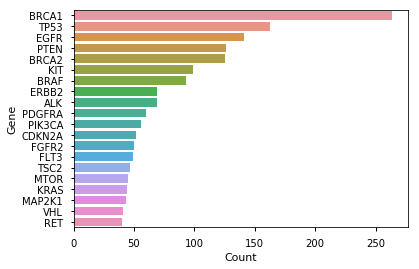

In [48]:
# Plot gene frequency for top 20 most frequently occuring genes in training data 
gene_var_df = pd.DataFrame({'Gene': variants_train['Gene'].value_counts().index,
                     'Count': variants_train['Gene'].value_counts()})
print(gene_var_df.shape)
sns.barplot(x=gene_var_df['Count'][:20], y=gene_var_df['Gene'][:20])
plt.show()

   Class  Count
7      7    953
4      4    686
1      1    568
2      2    452
6      6    275
5      5    242
3      3     89
9      9     37
8      8     19


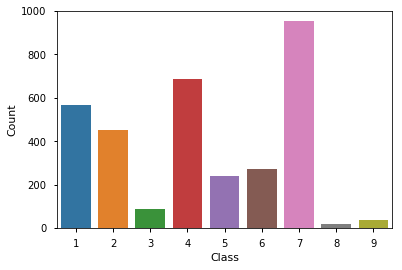

In [11]:
# Plot the occurrances of each class in training dataset

class_df = pd.DataFrame({'Class': variants_train['Class'].value_counts().index,
                     'Count': variants_train['Class'].value_counts()})

print(class_df)
sns.barplot(x=class_df['Class'], y=class_df['Count'])
plt.show()

As shown above, there is a disproportionate distribution of class appearances in the training dataset. Class 7 appears over 900 times while class 8 only appears 19 times. This is bound to affect what the model is going to learn. It probably won't be able to accurately classify the class 8 because it is exposed to so few examples of that class in the training dataset. One possible solution to this problem is to combine the training and testing datasets together and create a new train/validation/test set where the train set has more variety.

## Load Stage 2 Testing Data
---

In [4]:
text_test_2 = pd.read_csv('stage2_test_text.csv', delimiter='\|\|', skiprows=1,
                         names=['ID', 'Text'], engine='python').set_index('ID')

variants_test_2 = pd.read_csv('stage2_test_variants.csv', skiprows=1,
                          names=['ID', 'Gene', 'Variation'], engine='python').set_index('ID')

In [171]:
display(text_test_2.head())
display(variants_test_2.head())

,Text
ID,
1,The incidence of breast cancer is increasing i...
2,An unselected series of 310 colorectal carcino...
3,Mycosis fungoides and Sézary syndrome are prim...
4,Regulated progression through the cell cycle ...
5,Pilocytic astrocytoma (PA) is emerging as a tu...


,Gene,Variation
ID,,
1,CHEK2,H371Y
2,AXIN2,Truncating Mutations
3,WNT4,E216G
4,SUCLA2,G118R
5,BRAF,T599insTT


# Using Imbalanced-Learn
---
Here SMOTE (Synthetic Minority Over-Sampling Technique) is used to balance the class distribution.

In [5]:
# Define function to resample the data using SMOTE
def resample_data(X, y):
    X_resampled, y_resampled = SMOTE(random_state=21).fit_sample(X, y)
    return X_resampled, y_resampled

# Split Data into Train/Test Sets
---

In [6]:
# Define function to split the data into train/test sets
def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)
    return X_train, X_test, y_train, y_test

# Approach 1: Scikit-learn
---
Using Sci-kit learn to fit the training data to a MultinomialNB and RandomForestClassifier model.
First use CountVectorizer and TfidfTransformer to transform text data into numerical data.
Use Pipeline to make this process simpler, then use GridSearchCV to sift through several different parameters to find the optimal ones.

## Using Feature Extraction to Transform Text into Numerical Data
---
### MultinomialNB

In [13]:
# Process text data using CountVectorizer and TfidfTransformer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(text_train['Text']) # When using entire training set

In [15]:
# Display CountVectorizer training set info
print('Size of sparse matrix: {}'.format(X_train_counts.shape))
print('Number of non-zero occurences: {}'.format(X_train_counts.nnz))
print('Sparsity: {}'.format((100.0 * X_train_counts.nnz / (X_train_counts.shape[0] * X_train_counts.shape[1]))))

Size of sparse matrix: (3321, 155732)
Number of non-zero occurences: 5620942
Sparsity: 1.0868318756333166


In [16]:
# Use TfidfTransformer fit_transform method on X_train_counts
tf_transformer = TfidfTransformer()
X_train_tfidf = tf_transformer.fit_transform(X_train_counts)
print('Shape of X_train_tfidf:', X_train_tfidf.shape)

Shape of X_train_tfidf: (3321, 155732)


In [17]:
# Resample the data using imbalanced-learn and SMOTE
X_resampled, y_resampled = resample_data(X_train_tfidf, variants_train['Class'])

7    953
6    953
5    953
4    953
3    953
2    953
9    953
1    953
8    953
Name: Class, dtype: int64


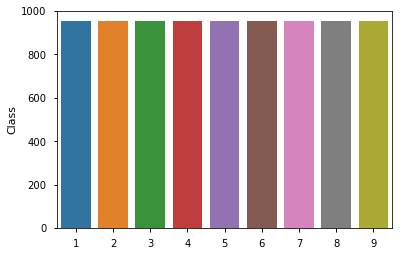

In [18]:
# Visualize classes after resampling data
resample_df = pd.DataFrame(y_resampled, columns=['Class'])

print(resample_df['Class'].value_counts())
sns.barplot(x=resample_df['Class'].value_counts().index, y=resample_df['Class'].value_counts())
plt.show()

In [19]:
# Split training data into train/test datasets

X_train, X_test, y_train, y_test = split_data(X_resampled, y_resampled)

print('X_train size: {}'.format(X_train.shape))
print('X_test size: {}'.format(X_test.shape))
print('y_train size: {}'.format(y_train.shape))
print('y_test size: {}'.format(y_test.shape))

X_train size: (6861, 155732)
X_test size: (1716, 155732)
y_train size: (6861,)
y_test size: (1716,)


In [20]:
# Create MultinomialNB Classifier
clf = MultinomialNB().fit(X_train, y_train)

In [21]:
# Make predictions
predicted = clf.predict(X_test)
predicted_log = clf.predict_log_proba(X_test)
predicted_prob = clf.predict_proba(X_test)

In [22]:
print(predicted_log.shape)
print(y_test.shape)

(1716, 9)
(1716,)


In [23]:
loss = log_loss(y_test, predicted_log)
acc = accuracy_score(y_test, predicted)
print('Log loss is: {}\n'.format(loss))
print('Accuracy is: {}\n'.format(acc))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

Log loss is: 2.197224577336219

Accuracy is: 0.6905594405594405

             precision    recall  f1-score   support

          1       0.64      0.47      0.55       194
          2       0.63      0.69      0.66       191
          3       0.81      0.72      0.76       197
          4       0.74      0.55      0.63       187
          5       0.48      0.70      0.57       188
          6       0.83      0.63      0.72       197
          7       0.54      0.58      0.56       179
          8       0.77      0.92      0.84       187
          9       0.89      0.95      0.92       196

avg / total       0.70      0.69      0.69      1716

[[ 92   3   5  18  48   9   6  10   3]
 [  3 131   1   1   3   1  38  12   1]
 [  1   3 142  14  32   0   5   0   0]
 [ 35   5   5 102  22   3   8   6   1]
 [  5   5   9   1 131  12  17   5   3]
 [  5  12   2   1  36 125  15   1   0]
 [  2  50  12   1   1   0 103   9   1]
 [  0   0   0   0   0   0   0 172  15]
 [  0   0   0   0   0   0   0   9 187

# Simplify above process with Pipeline
---
### MultinomialNB

Using MultinomialNB with Pipeline

In [8]:
# Do above again with Pipeline
text_clf_nb = imb_pipeline([('vect', CountVectorizer()),
                            ('tfidf', TfidfTransformer()),
                            ('sample', SMOTE(random_state=21)),
                            ('clf', MultinomialNB())])

In [8]:
# Split data
X_train, X_test, y_train, y_test = split_data(text_train['Text'], variants_train['Class'])

print('X_train size: {}'.format(X_train.shape))
print('X_test size: {}'.format(X_test.shape))
print('y_train size: {}'.format(y_train.shape))
print('y_test size: {}'.format(y_test.shape))

X_train size: (2656,)
X_test size: (665,)
y_train size: (2656,)
y_test size: (665,)


In [32]:
# Fit and predict for MultinomialNB
text_clf_nb.fit(X_train, y_train)
predicted = text_clf_nb.predict(X_test)
predicted_log = text_clf_nb.predict_log_proba(X_test)
predicted_prob = text_clf_nb.predict_proba(X_test)

In [33]:
# Report log loss, accuracy and classification report
loss = log_loss(y_test, predicted_log)
acc = accuracy_score(y_test, predicted)
print('MultinomialNB Results: ')
print('Log loss is: {}'.format(loss))
print('Accuracy is: {}\n'.format(acc))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

MultinomialNB Results: 
Log loss is: 2.1972245773362196
Accuracy is: 0.5338345864661654

             precision    recall  f1-score   support

          1       0.55      0.49      0.52       110
          2       0.43      0.67      0.53       107
          3       0.26      0.52      0.34        21
          4       0.74      0.50      0.60       129
          5       0.27      0.41      0.32        37
          6       0.82      0.65      0.73        63
          7       0.70      0.46      0.55       185
          8       0.05      0.50      0.09         2
          9       0.52      1.00      0.69        11

avg / total       0.61      0.53      0.55       665

[[54  7  2 15 13  8  3  5  3]
 [ 3 72  2  1  2  0 23  4  0]
 [ 1  1 11  3  3  0  2  0  0]
 [31  5  7 65 13  0  1  3  4]
 [ 5  7  4  1 15  1  3  0  1]
 [ 2  6  0  1  7 41  5  1  0]
 [ 3 68 17  2  3  0 85  6  1]
 [ 0  0  0  0  0  0  0  1  1]
 [ 0  0  0  0  0  0  0  0 11]]


# RandomForestClassifier

Using RandomForestClassifier with Pipeline

In [34]:
text_clf_rf = imb_pipeline([('vect', CountVectorizer()),
                            ('tfidf', TfidfTransformer()),
                            ('sample', SMOTE(random_state=21)),
                            ('clf', RandomForestClassifier(random_state=21))])

In [35]:
# Fit and predict for RandomForestClassifier
text_clf_rf.fit(X_train, y_train)
predicted = text_clf_rf.predict(X_test)
predicted_prob = text_clf_rf.predict_proba(X_test)
# Add 1e-12 to avoid divide by zero errors because some of the probabilities are 0.0
predicted_log = np.log(predicted_prob + 1e-12)

In [36]:
# Report log loss, accuracy and classification report
loss = log_loss(y_test, predicted_log)
acc = accuracy_score(y_test, predicted)
print('RandomForestClassifier Results: ')
print('Log loss is: {}'.format(loss))
print('Accuracy is: {}\n'.format(acc))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

RandomForestClassifier Results: 
Log loss is: 1.937211225006586
Accuracy is: 0.5729323308270676

             precision    recall  f1-score   support

          1       0.51      0.52      0.51       110
          2       0.55      0.53      0.54       107
          3       0.33      0.43      0.38        21
          4       0.59      0.63      0.61       129
          5       0.40      0.46      0.43        37
          6       0.81      0.70      0.75        63
          7       0.60      0.60      0.60       185
          8       0.00      0.00      0.00         2
          9       1.00      0.45      0.62        11

avg / total       0.58      0.57      0.58       665

[[ 57   4   2  24   9   6   8   0   0]
 [  7  57   0   7   2   1  33   0   0]
 [  0   0   9   5   1   2   4   0   0]
 [ 27   2   5  81   3   0  10   1   0]
 [  3   1   3   3  17   1   9   0   0]
 [  4   1   0   2   4  44   8   0   0]
 [ 12  38   8  10   6   0 111   0   0]
 [  0   0   0   1   0   0   1   0   0]
 [  2

# Grid Search for optimal parameters
---
### MultinomialNB

Use MultinomialNB with GridSearchCV

In [8]:
text_clf_nb = imb_pipeline([('vect', CountVectorizer()),
                           ('tfidf', TfidfTransformer()),
                           ('sample', SMOTE(random_state=21)),
                           ('clf', MultinomialNB())])

parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-1, 1e-2),}

gs_clf_nb = GridSearchCV(text_clf_nb, parameters, n_jobs=1, verbose=10)

In [11]:
# Fit and predict for MultinomialNB GridSearchCV
gs_clf_nb.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] tfidf__use_idf=True, vect__ngram_range=(1, 1), clf__alpha=0.1 ...
[CV]  tfidf__use_idf=True, vect__ngram_range=(1, 1), clf__alpha=0.1, score=0.5495495495495496, total=  37.5s
[CV] tfidf__use_idf=True, vect__ngram_range=(1, 1), clf__alpha=0.1 ...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


[CV]  tfidf__use_idf=True, vect__ngram_range=(1, 1), clf__alpha=0.1, score=0.580608793686584, total=  49.2s
[CV] tfidf__use_idf=True, vect__ngram_range=(1, 1), clf__alpha=0.1 ...


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.2min remaining:    0.0s


[CV]  tfidf__use_idf=True, vect__ngram_range=(1, 1), clf__alpha=0.1, score=0.5607264472190693, total=  37.8s
[CV] tfidf__use_idf=True, vect__ngram_range=(1, 2), clf__alpha=0.1 ...


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.1min remaining:    0.0s


[CV]  tfidf__use_idf=True, vect__ngram_range=(1, 2), clf__alpha=0.1, score=0.545045045045045, total= 2.4min
[CV] tfidf__use_idf=True, vect__ngram_range=(1, 2), clf__alpha=0.1 ...


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  6.5min remaining:    0.0s


[CV]  tfidf__use_idf=True, vect__ngram_range=(1, 2), clf__alpha=0.1, score=0.5828635851183765, total= 2.2min
[CV] tfidf__use_idf=True, vect__ngram_range=(1, 2), clf__alpha=0.1 ...


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.7min remaining:    0.0s


[CV]  tfidf__use_idf=True, vect__ngram_range=(1, 2), clf__alpha=0.1, score=0.565266742338252, total= 2.3min
[CV] tfidf__use_idf=False, vect__ngram_range=(1, 1), clf__alpha=0.1 ..


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 12.9min remaining:    0.0s


[CV]  tfidf__use_idf=False, vect__ngram_range=(1, 1), clf__alpha=0.1, score=0.5281531531531531, total=  34.3s
[CV] tfidf__use_idf=False, vect__ngram_range=(1, 1), clf__alpha=0.1 ..


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 13.7min remaining:    0.0s


[CV]  tfidf__use_idf=False, vect__ngram_range=(1, 1), clf__alpha=0.1, score=0.5546786922209695, total=  34.5s
[CV] tfidf__use_idf=False, vect__ngram_range=(1, 1), clf__alpha=0.1 ..


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 14.6min remaining:    0.0s


[CV]  tfidf__use_idf=False, vect__ngram_range=(1, 1), clf__alpha=0.1, score=0.5482406356413166, total=  34.5s
[CV] tfidf__use_idf=False, vect__ngram_range=(1, 2), clf__alpha=0.1 ..


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 15.5min remaining:    0.0s


[CV]  tfidf__use_idf=False, vect__ngram_range=(1, 2), clf__alpha=0.1, score=0.5416666666666666, total= 2.0min
[CV] tfidf__use_idf=False, vect__ngram_range=(1, 2), clf__alpha=0.1 ..
[CV]  tfidf__use_idf=False, vect__ngram_range=(1, 2), clf__alpha=0.1, score=0.5636978579481398, total= 2.0min
[CV] tfidf__use_idf=False, vect__ngram_range=(1, 2), clf__alpha=0.1 ..
[CV]  tfidf__use_idf=False, vect__ngram_range=(1, 2), clf__alpha=0.1, score=0.5561861520998865, total= 2.0min
[CV] tfidf__use_idf=True, vect__ngram_range=(1, 1), clf__alpha=0.01 ..
[CV]  tfidf__use_idf=True, vect__ngram_range=(1, 1), clf__alpha=0.01, score=0.5720720720720721, total=  34.4s
[CV] tfidf__use_idf=True, vect__ngram_range=(1, 1), clf__alpha=0.01 ..
[CV]  tfidf__use_idf=True, vect__ngram_range=(1, 1), clf__alpha=0.01, score=0.6042841037204059, total=  34.4s
[CV] tfidf__use_idf=True, vect__ngram_range=(1, 1), clf__alpha=0.01 ..
[CV]  tfidf__use_idf=True, vect__ngram_range=(1, 1), clf__alpha=0.01, score=0.5925085130533485,

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 46.7min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...o='auto', svm_estimator=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'tfidf__use_idf': (True, False), 'vect__ngram_range': [(1, 1), (1, 2)], 'clf__alpha': (0.1, 0.01)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [12]:
predicted = gs_clf_nb.predict(X_test)
predicted_log = gs_clf_nb.predict_log_proba(X_test)
predicted_prob = gs_clf_nb.predict_proba(X_test)

In [13]:
# Report log loss, accuracy and classification report
loss = log_loss(y_test, predicted_log)
acc = accuracy_score(y_test, predicted)
print('MultinomialNB Results: ')
print('Log loss is: {}'.format(loss))
print('Accuracy is: {}\n'.format(acc))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))
print('Best Estimator: ', gs_clf_nb.best_estimator_)
print('Best Params: ', gs_clf_nb.best_params_)

MultinomialNB Results: 
Log loss is: 2.1972245773362196
Accuracy is: 0.6180451127819548

             precision    recall  f1-score   support

          1       0.58      0.58      0.58       110
          2       0.54      0.58      0.56       107
          3       0.36      0.62      0.46        21
          4       0.74      0.63      0.68       129
          5       0.33      0.38      0.35        37
          6       0.87      0.62      0.72        63
          7       0.67      0.68      0.68       185
          8       0.33      0.50      0.40         2
          9       0.65      1.00      0.79        11

avg / total       0.64      0.62      0.62       665

[[ 64   3   2  19  10   5   4   1   2]
 [  2  62   0   3   2   0  38   0   0]
 [  0   1  13   4   1   0   2   0   0]
 [ 31   0   5  81   8   0   2   1   1]
 [  6   4   4   0  14   1   7   0   1]
 [  5   5   0   1   5  39   8   0   0]
 [  2  39  12   2   3   0 126   0   1]
 [  0   0   0   0   0   0   0   1   1]
 [  0   0   0

# Approach 2: spaCy and Keras
---
Use spaCy to preprocess text data into word vectors and feed into a multilayer perceptron using keras deep learning library.

In [6]:
# Initialize spacy english parser
nlp = spacy.load('en')

## Prepare Data for Deep Learning
---
### Clean up text, remove stopwords and transform to word vectors

In [23]:
# Clean text before feeding it to spaCy
punctuations = string.punctuation

# Define function to cleanup text and remove stopwords and puncuation
def cleanup_text(docs):
    texts = []
    for doc in docs:
        tokens = [tok.lower() for tok in doc.split() if (tok not in stopwords and tok not in punctuations)]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [ ]:
# Cleanup text and make sure it retains original shape
print('Original training data shape: ', text_train['Text'].shape)
text_train_cleaned = cleanup_text(text_train['Text'])
print('Cleaned up training data shape: ', text_train_cleaned.shape)

In [ ]:
# Parse documents and print some info
print('Parsing documents...')

start = time()

vectors_train = [doc.vector for doc in nlp.pipe(text_train_cleaned, batch_size=500, n_threads=1, 
                                                parse=False, tag=False, entity=False)]
vectors_train = np.array(vectors)

end = time()
print('Total time passed parsing documents: {} seconds'.format(end - start))
print('Total number of documents parsed: {}'.format(len(vectors_train)))
print('Number of words in first document: ', len(text_train['Text'][0]))
print('Number of words in second document: ', len(text_train['Text'][1]))
print('Size of vector embeddings: ', vectors_train.shape[1])
print('Shape of vectors embeddings matrix: ', vectors_train.shape)

In [26]:
# The vector is a numpy array
print('vectors type: ', type(vectors_train))
print('nlp type: ', type(nlp))

# Free up some memory. Delete cleaned text variable.
try:
    del text_train_cleaned
except NameError:
    print('text_train_cleaned already deleted.')

vectors type:  <class 'numpy.ndarray'>
nlp type:  <class 'spacy.en.English'>


In [132]:
# Transform labels into one hot encoded format.
y_train_proc = label_binarize(variants_train['Class'], classes=[1, 2, 3, 4, 5, 6, 7, 8, 9])
print('y_train shape: {}'.format(y_train_proc.shape))
print('y_train samples:')
print(y_train_proc[:5])

y_train samples:
[[1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]]
y_train shape: (3321, 9)


## Save Test Word Embeddings and Labels
---
To load it in use *np.load(filename)*

In [28]:
# Save word vectors and labels
np.save('word_embeddings/training_vectors.npy', vectors_train)
np.save('word_embeddings/training_labels.npy', y_train_proc)

In [50]:
# Load word vectors and labels into numpy arrays
vectors_train = np.load('word_embeddings/training_vectors.npy')
y_train_proc = np.load('word_embeddings/training_labels.npy')

# Check to see if they have the correct shape
print(vectors_train.shape)
print(y_train_proc.shape)

(3321, 300)
(3321, 9)


## Resample Data
---

In [51]:
# Resample the data using imbalanced-learn and SMOTE
X_resampled, y_resampled = resample_data(vectors_train, variants_train['Class'])

# Transform labels into one hot encoded format.
y_resampled = label_binarize(y_resampled, classes=[1, 2, 3, 4, 5, 6, 7, 8, 9])

print('Resampled vectors shape:', X_resampled.shape)
print('Resampled labels shape:', y_resampled.shape)
print('y_resampled shape: {}'.format(y_resampled.shape))
print('y_resampled samples:')
print(y_resampled[:5])

Resampled vectors shape: (8577, 300)
Resampled labels shape: (8577, 9)
y_resampled shape: (8577, 9)
y_resampled samples:
[[1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]]


## Split Word Embeddings Into Train/Test Sets
---

In [52]:
# Split into training and testing sets

X_train, X_test, y_train, y_test = split_data(X_resampled, y_resampled)

print('X_train size: {}'.format(X_train.shape))
print('X_val size: {}'.format(X_test.shape))
print('y_train size: {}'.format(y_train.shape))
print('y_val size: {}'.format(y_test.shape))

X_train size: (6861, 300)
X_val size: (1716, 300)
y_train size: (6861, 9)
y_val size: (1716, 9)


# Train With Keras Models
---
Using multi-layer perceptron, convolutional neural network, and recurrent neural network (LSTM)

In [53]:
# Expand dimensions to avoid errors when fitting data to keras model

# vectors_train = np.expand_dims(vectors_train, axis=2)
# print(vectors_train.shape)
# print(y_train_proc.shape)

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
print('Text train shape: ', X_test.shape)
print('Text test shape: ', X_test.shape)
print('Labels train shape: ', y_train.shape)
print('Labels test shape: ', y_test.shape)

Text train shape:  (1716, 300, 1)
Text test shape:  (1716, 300, 1)
Labels train shape:  (6861, 9)
Labels test shape:  (1716, 9)


In [54]:
# Free up some memory
try:
    del vectors_train, y_train_proc
    print('Variables deleted')
except NameError:
        print('Already deleted')

Variables deleted


In [47]:
# Define keras model

'''# Densely Connected Neural Network
# Log loss: 1.397288
# Kaggle Log Loss: 2.47576
model = Sequential()

model.add(Dense(512, activation='relu', kernel_initializer='he_normal', input_dim=300))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.2))
model.add(Dense(9, activation='softmax'))
'''


# Convolutional Neural Network  Log loss w/ 25 epochs: ~2.10795. Log loss with 100 epochs: ~1.44532
# Kaggle Log loss w/100 epochs: 2.96044
inputs = Input(shape=(300,1))

x = Conv1D(64, 3, strides=1, padding='same', activation='relu')(inputs)

#Cuts the size of the output in half, maxing over every 2 inputs
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(128, 3, strides=1, padding='same', activation='relu')(x)
x = GlobalMaxPooling1D()(x) 
outputs = Dense(9, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)


'''# Bidirectional LSTM   Log loss: ~1.77028
# Kaggle Log loss: 2.04779
inputs = Input(shape=(300,1))

x = Bidirectional(LSTM(64, return_sequences=True),   # I tried 1024 neurons but training was far too slow
                  merge_mode='concat')(inputs)
x = Dropout(0.2)(x)
x = Flatten()(x)
outputs = Dense(9, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
'''

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 300, 1)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 300, 64)           256       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 150, 64)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 150, 128)          24704     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 1161      
Total params: 26,121
Trainable params: 26,121
Non-trainable params: 0
_________________________________________________________________


In [48]:
# Compile the model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['acc'])

In [55]:
# Load ModelCheckpoint function from keras to save best model
# Save the best model as training data is fit to model
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.conv.25epochs.hdf5', 
                               verbose=1, save_best_only=True)

# Define number of epochs
epochs = 100

# Fit the model to the training data
estimator = model.fit(X_train, y_train,
                      validation_split=0.2,
                      epochs=epochs, batch_size=50,
                      callbacks=[checkpointer], verbose=1)

Train on 5488 samples, validate on 1373 samples
Epoch 1/100
5488/5488 [==============================] - 15s - loss: 2.1985 - acc: 0.1128 - val_loss: 2.2027 - val_acc: 0.0932
Epoch 2/100
5488/5488 [==============================] - 16s - loss: 2.1974 - acc: 0.1206 - val_loss: 2.1945 - val_acc: 0.1122
Epoch 3/100
5488/5488 [==============================] - 16s - loss: 2.1965 - acc: 0.1168 - val_loss: 2.1955 - val_acc: 0.0932
Epoch 4/100
5488/5488 [==============================] - 14s - loss: 2.1957 - acc: 0.1161 - val_loss: 2.1985 - val_acc: 0.1071
Epoch 5/100
5488/5488 [==============================] - 15s - loss: 2.1953 - acc: 0.1210 - val_loss: 2.1958 - val_acc: 0.1158
Epoch 6/100
5488/5488 [==============================] - 14s - loss: 2.1946 - acc: 0.1226 - val_loss: 2.1922 - val_acc: 0.1296
Epoch 7/100
5488/5488 [==============================] - 14s - loss: 2.1944 - acc: 0.1172 - val_loss: 2.1927 - val_acc: 0.1428
Epoch 8/100
5488/5488 [==============================] - 15s - 

5488/5488 [==============================] - 14s - loss: 1.8941 - acc: 0.3207 - val_loss: 1.8812 - val_acc: 0.2870
Epoch 54/100
5488/5488 [==============================] - 14s - loss: 1.8814 - acc: 0.3211 - val_loss: 1.8607 - val_acc: 0.3328
Epoch 55/100
5488/5488 [==============================] - 14s - loss: 1.8655 - acc: 0.3285 - val_loss: 1.8892 - val_acc: 0.2993
Epoch 56/100
5488/5488 [==============================] - 14s - loss: 1.8573 - acc: 0.3278 - val_loss: 1.8539 - val_acc: 0.3081
Epoch 57/100
5488/5488 [==============================] - 14s - loss: 1.8464 - acc: 0.3293 - val_loss: 1.8059 - val_acc: 0.3540
Epoch 58/100
5488/5488 [==============================] - 14s - loss: 1.8285 - acc: 0.3473 - val_loss: 1.7989 - val_acc: 0.3729
Epoch 59/100
5488/5488 [==============================] - 14s - loss: 1.8158 - acc: 0.3484 - val_loss: 1.7806 - val_acc: 0.3569
Epoch 60/100
5488/5488 [==============================] - 15s - loss: 1.8022 - acc: 0.3562 - val_loss: 1.7817 - val_a

5488/5488 [==============================] - 14s - loss: 1.5722 - acc: 0.4621 - val_loss: 1.5756 - val_acc: 0.4683
Epoch 82/100
5488/5488 [==============================] - 14s - loss: 1.5711 - acc: 0.4581 - val_loss: 1.6184 - val_acc: 0.4377
Epoch 83/100
5488/5488 [==============================] - 14s - loss: 1.5564 - acc: 0.4579 - val_loss: 1.5360 - val_acc: 0.4924
Epoch 84/100
5488/5488 [==============================] - 15s - loss: 1.5538 - acc: 0.4619 - val_loss: 1.4973 - val_acc: 0.4975
Epoch 85/100
5488/5488 [==============================] - 14s - loss: 1.5404 - acc: 0.4676 - val_loss: 1.5163 - val_acc: 0.4698
Epoch 86/100
5488/5488 [==============================] - 15s - loss: 1.5369 - acc: 0.4661 - val_loss: 1.5933 - val_acc: 0.4428
Epoch 87/100
5488/5488 [==============================] - 15s - loss: 1.5216 - acc: 0.4785 - val_loss: 1.4678 - val_acc: 0.5120
Epoch 88/100
5488/5488 [==============================] - 15s - loss: 1.5221 - acc: 0.4714 - val_loss: 1.4711 - val_a

In [56]:
print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" % 
      (100*estimator.history['acc'][-1], 100*estimator.history['val_acc'][-1]))

Training accuracy: 49.93% / Validation accuracy: 49.38%


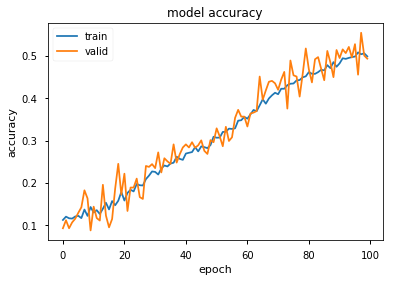

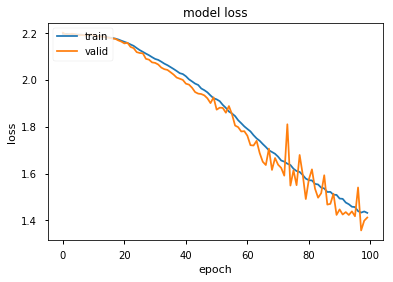

In [57]:
# Plot model accuracy and loss over epochs
# Summarize history for accuracy
plt.plot(estimator.history['acc'])
plt.plot(estimator.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(estimator.history['loss'])
plt.plot(estimator.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [58]:
# Free up some memory
try:
    del X_train, y_train
    print('Variables deleted')
except NameError:
    print('Already deleted')

Variables deleted


In [36]:
# Load the model with best loss

# bidirectional lstm model with 200 epochs and 50 batches and validation set
# model.load_weights('saved_models/weights.best.lstm.50epochs.hdf5')
# 1D Convolutional model with 50 epochs and 50 batches and validation set
model.load_weights('saved_models/weights.best.conv.100epochs.hdf5')

## If Evaluating on Kaggle Testing Set
---
If not, then skip to make predictions section.

In [24]:
# Transform testing data
print('Original testing data shape: ', text_test['Text'].shape)
text_test_cleaned = cleanup_text(text_test['Text'])
# text_test_cleaned = cleanup_text(text_test_2['Text'])  # If using stage 2 test data
print('Cleaned up testing data shape: ', text_test_cleaned.shape)

Original testing data shape:  (5668,)
Cleaned up testing data shape:  (986,)


In [25]:
# Transform text_test to word embeddings matrix
# Parse documents and print some statistics
print('Parsing documents...')

start = time()

vectors_test = [doc.vector for doc in nlp.pipe(text_test_cleaned, batch_size=500, n_threads=1, 
                                                parse=False, tag=False, entity=False)]
vectors_test = np.array(vectors_test)

end = time()
print('Total time passed parsing documents: {} seconds'.format(end - start))
print('Total number of documents parsed: {}'.format(len(vectors_test)))
print('Number of words in first document: ', len(text_test['Text'][0]))
print('Number of words in second document: ', len(text_test['Text'][1]))
print('Size of vector embeddings: ', vectors_test.shape[1])
print('Shape of vectors embeddings matrix: ', vectors_test.shape)

Parsing documents...
Total time passed parsing documents: 134.10319805145264 seconds
Total number of documents parsed: 986
Number of words in first document:  49829
Number of words in second document:  31326
Size of vector embeddings:  300
Shape of vectors embeddings matrix:  (986, 300)


In [26]:
# Free up some memory
try:
    del text_test_cleaned
    print('Variable deleted')
except NameError:
    print('Already deleted')

Variable deleted


## Save and load test word embeddings
---

In [29]:
# Save test word vectors
np.save('word_embeddings/testing_vectors.npy', vectors_test)

In [119]:
# Load word vectors into numpy arrays
vectors_test = np.load('word_embeddings/testing_vectors.npy')

# Check to see if it has the correct shape
print(vectors_test.shape)

(5668, 300)


In [28]:
# Expand dimensions (CNN or LSTM architecture) to avoid errors when predicting
vectors_test = np.expand_dims(vectors_test, axis=2)
print(vectors_test.shape)

(986, 300, 1)


## Make predictions
---

In [62]:
# Make predictions
predicted_prob = model.predict(vectors_test) # If evaluating on Kaggle test set
# predicted_prob = model.predict(X_test)       # If evaluating on homemade test set

In [63]:
# Make sure output is shaped correctly
print(predicted_prob.shape)

(986, 9)


In [61]:
# Report log loss and score
loss_sk = log_loss(y_test, predicted_prob)
print('SpaCy and Keras Results: ')
print('Log loss is: {}'.format(loss_sk))

SpaCy and Keras Results: 
Log loss is: 1.4453229891366406


# Approach 3: Doc2Vec
---
Train my own Doc2Vec model.

In [66]:
# First combine train and test text into one dataframe to make parsing text easier
all_text = np.concatenate((text_train, text_test), axis=0)
all_text = pd.DataFrame(all_text, columns=['Text'])
print('Number of total text documents:', len(all_text)) #8989

Number of total text documents: 8989


In [67]:
# Combine all gene/variation entries into one dataframe
train_data = pd.concat([variants_train, text_train], axis=1)
test_data = pd.concat([variants_test, text_test], axis=1)
train_data.drop(['Class', 'Text'], axis=1, inplace=True)
test_data.drop(['Text'], axis=1, inplace=True)

all_gene_var = np.concatenate((train_data, test_data), axis=0)
all_gene_var = pd.DataFrame(all_gene_var, columns=['Gene', 'Variation'])
print('Number of total gene/variation entries:', len(all_gene_var))

Number of total gene/variation entries: 8989


In [8]:
punctuations = string.punctuation

# Custom tokenizer
# Tokenizer parses through each document and removes stopwords, punctuation and personal pronouns
def spacy_tokenizer(sentence):
    tokens = nlp(sentence, parse=False, entity=False)
    tokens = [tok.lemma_.strip().lower() if tok.lemma_ != '-PRON-' else tok.lower_ for tok in tokens]
    tokens = [tok for tok in tokens if (tok not in stopwords and tok not in punctuations)]
    return tokens

vectorizer = CountVectorizer(analyzer='word', tokenizer=spacy_tokenizer)

In [ ]:
# Build tokenizer and tokenize all text using spacy tokenizer
print('Tokenizing all text documents...')
start = time()
tokenizer_spacy = vectorizer.build_tokenizer()
X_tok = [tokenizer_spacy(doc) for doc in all_text['Text']]
end = time()

print('Time elapsed: ', end-start)
print('Type of X_tok: ', type(X_tok))
print('Length of X_tok: ', len(X_tok))
print('Length of first doc in X_tok: ', len(X_tok[0]))

In [9]:
X_tok_proc = [' '.join(doc) for doc in X_tok]
print('X_tok_proc type: ', type(X_tok_proc))
print('Length of X_tok_proc: ', len(X_tok_proc))
print('Length of first document in X_tok_proc: ', len(X_tok_proc[0]))
print('Length of second document in X_tok_proc: ', len(X_tok_proc[1]))
# Free up memory
try:
    del X_tok
except NameError:
    print('X_tok already deleted')

X_tok_proc type:  <class 'list'>
Length of X_tok_proc:  8989
Length of first document in X_tok_proc:  28621
Length of second document in X_tok_proc:  25391


In [12]:
# Save array
with open("tokens/text_tokenized.txt", "wb") as fp:
    pickle.dump(X_tok_proc, fp)

In [10]:
# Load array
with open("/tokens/text_tokenized.txt", "rb") as fp:
    X_tok_proc = pickle.load(fp)

In [11]:
print('Spacy tokenizer text data shape: ', len(X_tok_proc))
print('Spacy tokenizer text data type', type(X_tok_proc))

Spacy tokenizer text data shape:  8989
Spacy tokenizer text data type <class 'list'>


In [30]:
from gensim.models.doc2vec import Doc2Vec, LabeledSentence
from gensim.utils import simple_preprocess, to_unicode

X_tok_labeled = []
for index, row in enumerate(X_tok_proc):
    X_tok_labeled.append(LabeledSentence(to_unicode(row).split(), ['Text' + '_%s' % str(index)]))

print('Data Type for X_tok_labeled:', type(X_tok_labeled))
print('Length of X_tok_labeled:', len(X_tok_labeled))
print('First 10 words of first labeled sentence:', X_tok_labeled[0].words[:10])
print('Tag for first labeled sentence', X_tok_labeled[0].tags)

Data Type for X_tok_labeled: <class 'list'>
Length of X_tok_labeled: 8989
First 10 words of first labeled sentence: ['cyclin', 'dependent', 'kinase', 'cdk', 'regulate', 'variety', 'fundamental', 'cellular', 'process', 'cdk10']
Tag for first labeled sentence ['Text_0']


In [65]:
from gensim.models.doc2vec import Doc2Vec
import os

text_dim = 300
filename = 'saved_models/train_vec.doc2vec'
docvec_model = None
if os.path.isfile(filename):
    # Load the model if it already exists
    docvec_model = Doc2Vec.load(filename)
else:
    # Instantiate the model
    docvec_model = Doc2Vec(size=text_dim, min_count=1, window=5, sample=1e-3, negative=5, iter=5, seed=21, workers=1)
    docvec_model.build_vocab(X_tok_labeled)
    docvec_model.train(X_tok_labeled, total_examples=docvec_model.corpus_count, epochs=docvec_model.iter)
    docvec_model.save(filename)

In [68]:
text_train_arrays = np.zeros((len(text_train), text_dim))
text_test_arrays = np.zeros((len(text_test), text_dim))

for i in range(len(text_train)):
    text_train_arrays[i] = docvec_model.docvecs['Text_'+ str(i)]

j = 0
for i in range(len(text_train),len(text_train)+len(text_test)):
    text_test_arrays[j] = docvec_model.docvecs['Text_'+ str(i)]
    j=j+1
    
print(text_train_arrays[0][:50])

[ 0.41375545 -0.71360081 -0.1231009  -0.16824475 -0.20684995 -0.50800437
  0.06112945 -0.26774201 -0.34364623  0.235286    0.09140928 -0.6722371
 -0.22423153 -0.77056545  0.0745403  -0.04036849  1.05884862 -0.98209226
 -0.90436548 -0.46791151 -0.41667029  0.75563878 -0.40877584  0.12701663
  0.66679621 -0.10872383  0.68086714 -0.29134139 -0.08604976  0.66326547
 -0.13777106  0.19371484  0.28705668  0.53506428  0.58203298  0.02151972
 -1.28696048 -0.19745786  0.2833249  -0.29673967 -0.52164167  0.5949288
 -0.90866572 -0.45721197 -0.47721899 -0.44971585 -0.13488626  0.08794958
  0.21903233 -0.91801637]


In [69]:
from sklearn.decomposition import TruncatedSVD
gene_dim = 25

svd = TruncatedSVD(n_components=25, n_iter=gene_dim, random_state=21)

one_hot_gene = pd.get_dummies(all_gene_var['Gene'])
truncated_one_hot_gene = svd.fit_transform(one_hot_gene.values)

one_hot_variation = pd.get_dummies(all_gene_var['Variation'])
truncated_one_hot_variation = svd.fit_transform(one_hot_variation.values)

print('Shape of one-hot encoded gene:', one_hot_gene.shape)
print('Shape of one-hot encoded variation:', one_hot_variation.shape)
print('Shape of truncated one-hot encoded gene: ({}, {})'.format(len(truncated_one_hot_gene), len(truncated_one_hot_gene[0])))
print('Shape of truncated one-hot encoded variation: ({}, {})'.format(len(truncated_one_hot_variation), len(truncated_one_hot_variation[0])))

Shape of one-hot encoded gene: (8989, 1507)
Shape of one-hot encoded variation: (8989, 8609)
Shape of truncated one-hot encoded gene: (8989, 25)
Shape of truncated one-hot encoded variation: (8989, 25)


In [70]:
# Merge train and test set together.
X_train = np.hstack((truncated_one_hot_gene[:len(text_train)],
                     truncated_one_hot_variation[:len(text_train)],
                     text_train_arrays))

X_test_1 = np.hstack((truncated_one_hot_gene[len(text_train):],
                    truncated_one_hot_variation[len(text_train):],
                    text_test_arrays))

print(X_train.shape)
print(X_test_1.shape)

(3321, 350)
(5668, 350)


In [71]:
# Use imbalanced-learn
X_resampled, y_resampled = resample_data(X_train, variants_train['Class'])
print(X_resampled.shape)
print(y_resampled.shape)

(8577, 350)
(8577,)


In [72]:
# Transform labels into one hot encoded format.
y_train_encoded = label_binarize(y_resampled, classes=[1, 2, 3, 4, 5, 6, 7, 8, 9])
print('y_train_encoded samples:')
print(y_train_encoded[:5])
print('y_train_encoded shape: {}'.format(y_train_encoded.shape))

y_train_encoded samples:
[[1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]]
y_train_encoded shape: (8577, 9)


## Split Word Embeddings Into Train/Test Sets
---

In [73]:
# Split into training and testing sets

X_train, X_test, y_train, y_test = split_data(X_resampled, y_train_encoded)

print('X_train size: {}'.format(X_train.shape))
print('X_test size: {}'.format(X_test.shape))
print('y_train size: {}'.format(y_train.shape))
print('y_test size: {}'.format(y_test.shape))

X_train size: (6861, 350)
X_test size: (1716, 350)
y_train size: (6861, 9)
y_test size: (1716, 9)


In [31]:
# Expand dimensions so it works for CNN
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
print('Text train shape: ', X_train.shape)
print('Text test shape: ', X_test.shape)

Text train shape:  (6861, 350, 1)
Text test shape:  (1716, 350, 1)


## Define Keras Neural Network Model
---

In [79]:
'''# Log loss w/ normal init: 0.65002. LL w/ he_normal:  0.682482. LL w/ double neurons: 0.658041
# Kaggle Log loss w/ normal init: 19.45819
model = Sequential()
model.add(Dense(1024, input_dim=text_dim + gene_dim*2, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, kernel_initializer='normal', activation='relu'))
model.add(Dense(9, kernel_initializer='normal', activation="softmax"))
'''

'''# Log loss: 1.82853. LL w/ Bidirectional: 1.8237032. LL w/ kernel_init: 1.8244. 
# Log loss w/ 2 layer LSTM (256 & 128 cells) return_seq=True & go_backwards=True: 1.83524
# Log loss w/ stacked Bidirectional LSTM layers (128 & 64 cells) return_seq=True & go_backwards=True: 1.8187873
# Kaggle LL: 1.92953. LL w/ return=sequences=True: 3.96760. LL w/ stacked Bidirectional LSTM: 1.93370
model = Sequential()
model.add(Bidirectional(LSTM(128, kernel_initializer='normal', return_sequences=True,
                             recurrent_dropout=0.2, dropout=0.2), input_shape=(text_dim + gene_dim*2, 1)))
# Uncomment next model.add line for 2 layer bidirectional LSTM model
# model.add(Bidirectional(LSTM(64, kernel_initializer='normal',
#                              recurrent_dropout=0.2, dropout=0.2, go_backwards=True)))
# Alternative LSTM model: 2-layer LSTM.
# model.add(LSTM(256, kernel_initializer='normal', return_sequences=True,
#                recurrent_dropout=0.2, dropout=0.2, input_shape=(text_dim + gene_dim*2, 1)))
# model.add(LSTM(128, kernel_initializer='normal', go_backwards=True))
# model.add(Flatten())
model.add(Dense(9, activation='softmax'))
'''

# Keras model. LL: ~1.9648. LL w/ dropout: ~1.913. LL w/ modifications: ~1.86835
# Log Loss: 1.407933
# Kaggle LL: 1.95406
model = Sequential()
# 128, 5, No stride or padding
model.add(Conv1D(64, 3, strides=1, padding='valid', activation='relu', input_shape=(text_dim + gene_dim*2, 1)))
model.add(Dropout(0.3))
model.add(MaxPooling1D(2))   # 5
# 128, 5, No stride or padding
model.add(Conv1D(64, 3, padding='valid', activation='relu'))  
model.add(Dropout(0.3))
# model.add(MaxPooling1D(5))
# model.add(Conv1D(128, 5, activation='relu'))
# model.add(Dropout(0.3))
model.add(GlobalMaxPooling1D())  # global max pooling
model.add(Dense(500, activation='relu'))      # OG: 128
model.add(Dense(9, activation='softmax'))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 2048)              718848    
_________________________________________________________________
dropout_10 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_11 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               131328    
__________

In [80]:
# Define optimizer and compile model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)  
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [81]:
# Fit the model

epochs = 40

estimator = model.fit(X_train, y_train,
                      validation_split=0.2,
                      epochs=epochs, batch_size=64,
                      verbose=1)

Train on 5488 samples, validate on 1373 samples
Epoch 1/40
5488/5488 [==============================] - 9s - loss: 1.8929 - acc: 0.2892 - val_loss: 1.3459 - val_acc: 0.4945
Epoch 2/40
5488/5488 [==============================] - 9s - loss: 1.3808 - acc: 0.4856 - val_loss: 1.0447 - val_acc: 0.6242
Epoch 3/40
5488/5488 [==============================] - 9s - loss: 1.1624 - acc: 0.5685 - val_loss: 0.9333 - val_acc: 0.6635
Epoch 4/40
5488/5488 [==============================] - 9s - loss: 1.0271 - acc: 0.6272 - val_loss: 0.8426 - val_acc: 0.6897
Epoch 5/40
5488/5488 [==============================] - 9s - loss: 0.9394 - acc: 0.6589 - val_loss: 0.8137 - val_acc: 0.7028
Epoch 6/40
5488/5488 [==============================] - 9s - loss: 0.8397 - acc: 0.6926 - val_loss: 0.7695 - val_acc: 0.7101
Epoch 7/40
5488/5488 [==============================] - 9s - loss: 0.7654 - acc: 0.7165 - val_loss: 0.7613 - val_acc: 0.7218
Epoch 8/40
5488/5488 [==============================] - 9s - loss: 0.6963 - a

In [82]:
print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" %
      (100*estimator.history['acc'][-1], 100*estimator.history['val_acc'][-1]))

Training accuracy: 94.72% / Validation accuracy: 85.36%


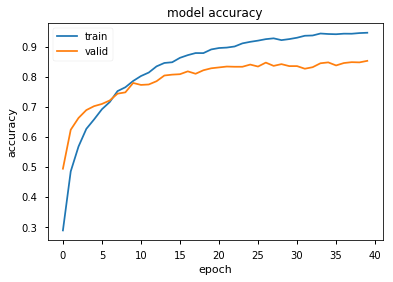

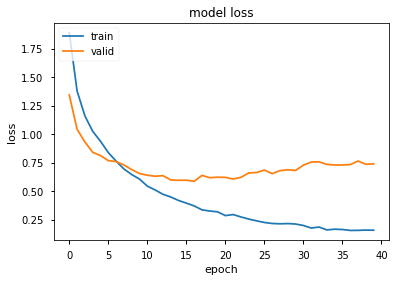

In [83]:
# summarize history for accuracy
plt.plot(estimator.history['acc'])
plt.plot(estimator.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(estimator.history['loss'])
plt.plot(estimator.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [84]:
# Make predictions
predicted_prob = model.predict_proba(X_test)

1664/1716 [============================>.] - ETA: 0s

In [85]:
# Report log loss and score
loss_sk = log_loss(y_test, predicted_prob)
print('SpaCy and Keras Results: ')
print('Log loss is: {}'.format(loss_sk))

SpaCy and Keras Results: 
Log loss is: 0.6580418596415951


## Evaluate Predictions on Stage 1 Filtered Solutions
---
Load the labels for testing set

In [42]:
y_test = pd.read_csv('stage1_solution_filtered.csv', skiprows=1,
                          names=['ID', 'class1', 'class2', 'class3', 'class4', 'class5',
                                 'class6', 'class7', 'class8', 'class9'], engine='python').set_index('ID')

y_pred = pd.read_csv('submission14.txt', skiprows=1,
                          names=['ID', 'class1', 'class2', 'class3', 'class4', 'class5',
                                 'class6', 'class7', 'class8', 'class9'], engine='python').set_index('ID')

In [43]:
# Filter the predictions
ids = np.array(y_test.index)
y_pred_filt = y_pred.filter(ids, axis='index')
print('Shape of filtered predictions:', y_pred_filt.shape)
print('Shape of filtered labels:', y_test.shape)
display(y_pred_filt.head())

Shape of filtered predictions: (368, 9)
Shape of filtered labels: (368, 9)


,class1,class2,class3,class4,class5,class6,class7,class8,class9
ID,,,,,,,,,
12,0.00,0.00,0.0,0.02,0.00,0.00,0.98,0.0,0.0
19,0.00,0.25,0.0,0.00,0.01,0.61,0.12,0.0,0.0
21,1.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0
55,0.99,0.00,0.0,0.01,0.00,0.00,0.00,0.0,0.0
64,0.00,0.00,0.0,0.00,0.00,0.00,1.00,0.0,0.0


In [44]:
# Evaluate predictions
# Report log loss and score
loss_sk = log_loss(y_test, y_pred_filt)
# score_sk = model.evaluate(X_test, y_test)
print('SpaCy, Doc2Vec and Keras Results: ')
print('Log loss is: {}'.format(loss_sk))
# print('Score (Log loss) is: {}'.format(score_sk))

SpaCy, Doc2Vec and Keras Results: 
Log loss is: 19.141371765656235


# Approach 4: GloVe Word Embeddings
---
From keras blog post: https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
### Text Preprocessing
Still using spaCy for text cleaning, in similar manner to approach 2.

In [7]:
# Create English spaCy model
nlp = spacy.load('en')

In [8]:
punctuations = string.punctuation

# Custom tokenizer
# Tokenizer parses through each document and removes stopwords, punctuation and personal pronouns
def spacy_tokenizer(sentence):
    tokens = nlp(sentence, parse=False, entity=False)
    tokens = [tok.lemma_.strip().lower() if tok.lemma_ != '-PRON-' else tok.lower_ for tok in tokens]
    tokens = [tok for tok in tokens if (tok not in stopwords and tok not in punctuations)]
    return tokens

vectorizer = CountVectorizer(analyzer='word', tokenizer=spacy_tokenizer)

In [9]:
# Build tokenizer and tokenize all text using spacy tokenizer
print('Tokenizing training text documents...')
start = time()
tokenizer_spacy = vectorizer.build_tokenizer()
X_tok = [tokenizer_spacy(doc) for doc in text_train['Text']]  # text_train['Text']
end = time()

print('Time elapsed: ', end-start)
print('Type of X_tok: ', type(X_tok))
print('Length of X_tok: ', len(X_tok))
print('Length of first doc in X_tok: ', len(X_tok[0]))

Tokenizing training text documents...
Time elapsed:  671.5140810012817
Type of X_tok:  <class 'list'>
Length of X_tok:  3321
Length of first doc in X_tok:  4114


In [10]:
X_tok_proc = [' '.join(doc) for doc in X_tok]
print('X_tok_proc type: ', type(X_tok_proc))
print('Length of X_tok_proc: ', len(X_tok_proc))
print('Length of first document in X_tok_proc: ', len(X_tok_proc[0]))
print('Length of second document in X_tok_proc: ', len(X_tok_proc[1]))
# Free up memory
try:
    del X_tok
    print('Variable deleted')
except NameError:
    print('X_tok already deleted')

X_tok_proc type:  <class 'list'>
Length of X_tok_proc:  3321
Length of first document in X_tok_proc:  28621
Length of second document in X_tok_proc:  25391
Variable deleted


In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_num_words = 2000

tokenizer = Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(X_tok_proc)
sequences = tokenizer.texts_to_sequences(X_tok_proc)

# Uncomment when evaluating test set
# tokenizer_test = Tokenizer(num_words=max_num_words)
# tokenizer_test.fit_on_texts(X_tok_proc)
# sequences_test = tokenizer_test.texts_to_sequences(X_tok_proc)

word_index_train = tokenizer.word_index
# word_index_test = tokenizer_test.word_index
print('Found %s unique tokens in training set.' % len(word_index_train))
# print('Found %s unique tokens in testing set.' % len(word_index_test))

Using TensorFlow backend.


Found 164578 unique tokens in training set.


In [16]:
# Pad the train/test sequences
max_seq_len = 1000

data = pad_sequences(sequences, maxlen=max_seq_len)
# data_test = pad_sequences(sequences_test, maxlen=max_seq_len)

print('Shape of data tensor:', data.shape)
# print('Shape of data test tensor:', data_test.shape)

Shape of data tensor: (3321, 1000)


In [17]:
data, y_resampled = resample_data(data, variants_train['Class'])
print('Shape of data tensor:', data.shape)

Shape of data tensor: (8577, 1000)


In [18]:
labels = label_binarize(y_resampled, classes=[1, 2, 3, 4, 5, 6, 7, 8, 9])
print('Shape of label tensor:', labels.shape)

Shape of label tensor: (8577, 9)


In [19]:
# Split data into train/val set

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_val_samples = int(0.2 * data.shape[0])
print(indices[:5])

X_train = data[:-num_val_samples]
y_train = labels[:-num_val_samples]
X_test = data[-num_val_samples:]
y_test = labels[-num_val_samples:]


[6053 3026 6174 4810 3224]


### Creating Word Embeddings from Glove

In [20]:
import os

glove_dir = 'glove/'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [21]:
embedding_dim = 100 # Number of dimensions in glove txt file
embedding_matrix = np.zeros((len(word_index_train) + 1, embedding_dim))
for word, i in word_index_train.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embeddings index will be all zeros
        embedding_matrix[i] = embedding_vector

### Define Keras Model
---

In [22]:
embedding_layer = Embedding(len(word_index_train) + 1, embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_seq_len,
                            trainable=False)

In [30]:
# Keras model. Log loss: 3.01928
# Kaggle LL: 7.54333
sequence_input = Input(shape=(max_seq_len,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x)  # global max pooling
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(9, activation='softmax')(x)

model = Model(sequence_input, preds)

'''
# OG Log loss ~1.416. Log loss w/ 20 epochs ~1.20465. Log loss w/o trainable ~1.33426. Log loss w/ Dropout ~1.3740
# Log loss w/ Dense layer at end ~1.3338. 
# Log loss w/ imbalanced-learn: ~1.866291
_input = Input(shape=(max_seq_len,), dtype='int32')
_embedding = Embedding(len(word_index_train) + 1, embedding_dim,
                       input_length=max_seq_len)(_input)

# each filter is (3 x 300 ) array of weights
# window (kernel_size) is 3
# so number of weights is (3 * 300 * 64)
# each filter outputs a (200 / strides) x 1 transformation
# padding is how we handle boundaries. include + pad, ignore, etc
_conv_1 = Conv1D(64, 3, strides=1, padding='valid')(_embedding)

#Cuts the size of the output in half, maxing over every 2 inputs
_pool_1 = MaxPooling1D(pool_size=2)(_conv_1)
_conv_2 = Conv1D(64, 3, padding='valid')(_pool_1)
_pool_2 = GlobalMaxPooling1D()(_conv_2) 
_activation = Activation('relu')(_pool_2)
_dense_1 = Dense(500, activation='relu')(_activation)

output = Dense(9,  activation='softmax')(_dense_1)

model = Model(inputs=_input, outputs=output)
'''

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         16457900  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 35, 128)           82048     
__________

In [31]:
# Compile the model
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['acc'])

In [32]:
# Load ModelCheckpoint function from keras to save best model
# Save the best model as training data is fit to model
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.conv.glove.35epochs.hdf5', 
                               verbose=1, save_best_only=True)

# Define number of epochs
epochs = 35

estimator = model.fit(X_train, y_train, validation_split=0.2,
                      epochs=epochs, batch_size=32,
                      callbacks=[checkpointer], verbose=1)

Train on 5489 samples, validate on 1373 samples
Epoch 1/35
5489/5489 [==============================] - 85s - loss: 1.9071 - acc: 0.3055 - val_loss: 1.6860 - val_acc: 0.3831
Epoch 2/35
5489/5489 [==============================] - 92s - loss: 1.4708 - acc: 0.4770 - val_loss: 1.5834 - val_acc: 0.4916
Epoch 3/35
5489/5489 [==============================] - 84s - loss: 1.2914 - acc: 0.5400 - val_loss: 1.6312 - val_acc: 0.4574
Epoch 4/35
5489/5489 [==============================] - 80s - loss: 1.1751 - acc: 0.5890 - val_loss: 1.3641 - val_acc: 0.5098
Epoch 5/35
5489/5489 [==============================] - 79s - loss: 1.0638 - acc: 0.6371 - val_loss: 1.3667 - val_acc: 0.5084
Epoch 6/35
5489/5489 [==============================] - 80s - loss: 0.9819 - acc: 0.6715 - val_loss: 1.6744 - val_acc: 0.4064
Epoch 7/35
5489/5489 [==============================] - 80s - loss: 0.9128 - acc: 0.6879 - val_loss: 1.6085 - val_acc: 0.4698
Epoch 8/35
5489/5489 [==============================] - 79s - loss: 0.

In [19]:
model.load_weights('saved_models/weights.best.lstm.glove.35epochs.hdf5')

In [33]:
print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" % 
      (100*estimator.history['acc'][-1], 100*estimator.history['val_acc'][-1]))

Training accuracy: 87.63% / Validation accuracy: 51.86%


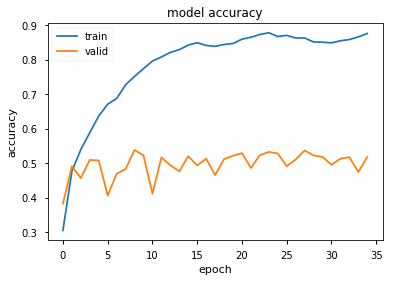

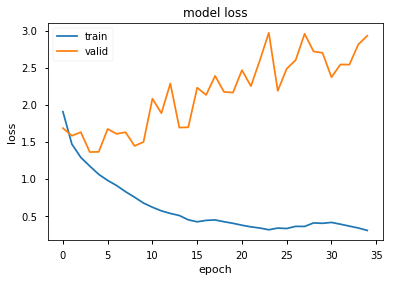

In [34]:
# summarize history for accuracy
plt.plot(estimator.history['acc'])
plt.plot(estimator.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(estimator.history['loss'])
plt.plot(estimator.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [35]:
# Make predictions
predicted_prob = model.predict(X_test)

In [56]:
# Make sure output is shaped correctly
print(predicted_prob.shape)

(664, 9)


In [36]:
# Report log loss and score
loss_sk = log_loss(y_test, predicted_prob)
print('SpaCy and Keras Results: ')
print('Log loss is: {}'.format(loss_sk))

SpaCy and Keras Results: 
Log loss is: 3.01928885747825


# Saving final probabilities to text file
---
The output of this code cell is a file named "submission.txt" and is ready for submission to Kaggle.

In [38]:
print(predicted_prob.shape)

(986, 9)


In [41]:
# Save submission file
with open('submission14.txt', 'w') as file_obj:
    file_obj.write('ID,class1,class2,class3,class4,class5,class6,class7,class8,class9\n')
    for pred in range(len(predicted_prob)):
        file_obj.write(str(pred+1) + ',' + ','.join('{:.2f}'.format(s) for s in predicted_prob[pred].tolist()) + '\n')

In [62]:
# Save submission file for stage 2
with open('submission24.csv', 'w') as file_obj:
    file_obj.write('ID,class1,class2,class3,class4,class5,class6,class7,class8,class9\n')
    for pred in range(len(predicted_prob)):
        file_obj.write(str(pred+1) + ',' + ','.join('{:.2f}'.format(s) for s in predicted_prob[pred].tolist()) + '\n')

# Visualizing Log Loss Scores
---

In [2]:
score = [2.1972, 2.19722, 5.09670, 7.33243,
         1.9372, 2.98226,
         1.397288, 2.47576,
         2.10795, 1.44532, 2.96044,
         1.77028, 2.04779,
         0.65002, 19.45819,
         1.86835, 1.95406,
         1.8187873, 1.93370, 1.92953,
         3.01928, 7.54333,
         3.01928, 7.54333]
architecture = ['MultinomialNB', 'MultinomialNB', 'MultinomialNB', 'MultinomialNB',
                'RandomForestClassifier', 'RandomForestClassifier',
                'MLP', 'MLP',
                'CNN', 'CNN', 'CNN',
                'LSTM', 'LSTM',
                'MLP', 'MLP',
                'CNN', 'CNN',
                'LSTM', 'LSTM', 'LSTM',
                'MLP', 'MLP',
                'CNN', 'CNN']
approach = ['1', '1', '1', '1', '1', '1', '2', '2', '2', '2', '2', '2', '2',
            '3', '3', '3', '3', '3', '3', '3', '4', '4', '4', '4']
score_type = ['sklearn', 'sklearn w/ GridSearchCV', 'Kaggle w/ GridSearchCV', 'Kaggle', # Approach 1: MultinomialNB
              'sklearn', 'Kaggle',  # RandomForestClassifier
              'sklearn w/ 25 epochs', 'Kaggle',  # Approach 2: MLP
              'sklearn w/ 25 epochs', 'sklearn w/ 100 epochs', 'Kaggle',  # CNN
              'sklearn w/ 25 epochs', 'Kaggle',  # LSTM
              'sklearn', 'Kaggle',  # Approach 3: MLP
              'sklearn', 'Kaggle',  # CNN
              'sklearn w/ 2 layers', 'Kaggle w/ 2 layers', 'Kaggle 1-layer No Bidirectional', # LSTM
              'sklearn', 'Kaggle',  # Approach 4: MLP
              'sklearn', 'Kaggle']  # CNN

data = pd.DataFrame({'score': score, 'architecture': architecture, 'approach': approach, 'score_type': score_type})
display(data.head())

,approach,architecture,score,score_type
0,1,MultinomialNB,2.19720,sklearn
1,1,MultinomialNB,2.19722,sklearn w/ GridSearchCV
2,1,MultinomialNB,5.09670,Kaggle w/ GridSearchCV
3,1,MultinomialNB,7.33243,Kaggle
4,1,RandomForestClassifier,1.93720,sklearn


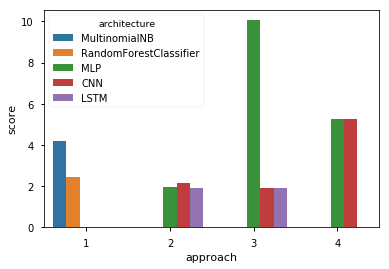

In [27]:
sns.barplot(x='approach', y='score', hue='architecture', data=data, ci=None)
plt.show()